In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 
from tensorflow.keras import Model
from tensorflow.keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
pip list | grep tensorflow

In [22]:
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = IMAGE_SIZE + (3,)
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 32

In [5]:
gdrive_dir = "/content/drive/MyDrive"
working_dir = os.path.join(gdrive_dir, "CS3244 Project")
data_dir = os.path.join(working_dir, "landmarks/international/data_split/8")
model_root_dir = os.path.join(working_dir, "models/xihao")

In [8]:
num_of_labels = len(os.listdir(data_dir))

print('number of local labels:', num_of_labels)

number of local labels: 200


In [9]:
# dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear")

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255, 
    validation_split = VALIDATION_SPLIT,
    rotation_range = 30,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range = [0.9,1.1],
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training", 
    shuffle = True, 
    target_size = IMAGE_SIZE ,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split = VALIDATION_SPLIT
)
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation", 
    shuffle = False, 
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'categorical'
)

Found 1737 images belonging to 200 classes.
Found 345 images belonging to 200 classes.


In [23]:
nasnet_model = NASNetMobile(
    input_shape = INPUT_SHAPE,
    include_top = False,
    weights='imagenet'
)

In [24]:
nasnet_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [25]:
last_layer = nasnet_model.get_layer("activation_375")
last_output = last_layer.output

In [27]:
last_output_count = 1024

x = layers.Flatten()(last_output)
x = layers.Dense(last_output_count, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(last_output_count/2, activation='relu')(x)
x = layers.Dense(num_of_labels, activation='softmax')(x)

model = Model(nasnet_model.input, x)

In [28]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
    metrics = ['accuracy']
)

In [29]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [30]:
steps_per_epoch = int(train_generator.samples / BATCH_SIZE)
validation_steps = int(validation_generator.samples / BATCH_SIZE)

print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Steps per epoch: 54
Validation steps: 10


In [31]:
history = model.fit(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 60,
    validation_data = validation_generator,
    # validation_steps = validation_steps
)


Epoch 1/60
54/54 [==============================] - 900s 15s/step - loss: 13.7830 - accuracy: 0.1102 - val_loss: 15.8995 - val_accuracy: 0.2058
Epoch 2/60
54/54 [==============================] - 68s 1s/step - loss: 3.9501 - accuracy: 0.2549 - val_loss: 342.8018 - val_accuracy: 0.2029
Epoch 3/60
54/54 [==============================] - 68s 1s/step - loss: 3.1657 - accuracy: 0.4223 - val_loss: 686.3810 - val_accuracy: 0.2029
Epoch 4/60
54/54 [==============================] - 68s 1s/step - loss: 2.6025 - accuracy: 0.5037 - val_loss: 302.2822 - val_accuracy: 0.2029
Epoch 5/60
54/54 [==============================] - 68s 1s/step - loss: 2.3060 - accuracy: 0.5603 - val_loss: 5351.0483 - val_accuracy: 0.2029
Epoch 6/60
54/54 [==============================] - 68s 1s/step - loss: 2.1809 - accuracy: 0.5789 - val_loss: 25712.5566 - val_accuracy: 0.2029
Epoch 7/60
54/54 [==============================] - 67s 1s/step - loss: 1.8698 - accuracy: 0.6271 - val_loss: 56933.0898 - val_accuracy: 0.2029

In [ ]:
save_model_name = "imagenet_nasnet_large_classification_1"
save_model_dir = os.path.join(model_root_dir, save_model_name)
tf.keras.models.save_model(model)

Text(0.5, 1.0, 'Training and validation loss')

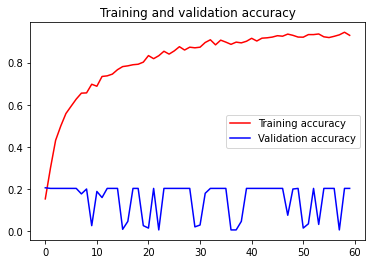

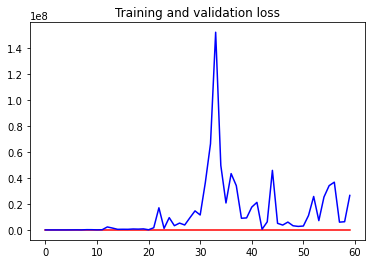

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')